In [1]:
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch


from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
ROOT_PATH = 'logs/none/routing'  # Can use shell globbing here.
ROWS_TO_DISPLAY = 10

In [ ]:
def get_varied_parameters():
    with open('hyperparameters_config.json') as f:
        hyperparameter_config = json.loads(f.read())

    return [param for param, vals in hyperparameter_config.items()
            if len(vals) > 1]

def get_parameter_table(root):
    varied_parameters = get_varied_parameters()
    param_dict = {'timestamp': []}
    for param in varied_parameters:
        param_dict[param] = []
    
    for file in glob.glob(os.path.join(root, '*')):
        with open(os.path.join(file, 'experiment_config.json')) as f:
            exp_data = json.loads(f.read())

        param_dict['timestamp'].append(os.path.split(file)[-1])
        for param, val in exp_data.items():
            if param in varied_parameters:
                param_dict[param].append(val)
                
    return pd.DataFrame(param_dict) 

def get_activations(path):
    with open(os.path.join(path, 'average_activations.json')) as f:
        data = json.loads(f.read())
    return data

def get_activation_similarities(path, stripewise=True):
    avg_activations = torch.tensor(get_activations(path))
    if stripewise:
        avg_activations = avg_activations.mean(2)
    return [[torch.norm(avg_activations[i] - avg_activations[j]).item()
             for j in range(10)]
            for i in range(10)]

def get_topk_most_diverse(root, stripewise=True):
    pairs = []
    for timestamp in table['timestamp']:
        path = os.path.join(root, timestamp)
        score = torch.norm(torch.tensor(get_activation_similarities(path, stripewise=stripewise)))
        pairs.append([score.item(), path])
    pairs.sort()
    return pairs

table = get_parameter_table(ROOT_PATH)
table['overall_diversity'] = [score for score, _ in get_topk_most_diverse(ROOT_PATH)]
table['stripewise_diversity'] = [score for score, _ in get_topk_most_diverse(ROOT_PATH, stripewise=True)]

# Basic Results

### Static Parameters

In [4]:
def get_static_parameters():
    with open('hyperparameters_config.json') as f:
        hyperparameter_config = json.loads(f.read())

    static_config = {}
    for param, vals in hyperparameter_config.items():
        if len(vals) == 1:
            print('{:30} {:20}'.format(param, str(vals[0])))

get_static_parameters()

intermediate_dim               250                 
num_stripes                    30                  
layer_sparsity_mode            none                
stripe_sparsity_mode           routing             
alpha                          0.8                 
beta                           1.2                 
routing_l1_regularization      0.0                 
log_average_routing_scores     True                
active_stripes_per_batch       1.0                 
lr                             0.01                
momentum                       0.9                 
num_epochs                     12                  
batch_size                     8                   
data_path                      data.csv            
log_path                       logs                
log_class_specific_losses      False               
log_average_activations        True                
log_experiment_flags           True                
use_cuda_if_available          True                


### Experiments with Highest Overall Diversity

In [5]:
table.sort_values('overall_diversity')
table.head(ROWS_TO_DISPLAY)

,timestamp,stripe_dim,num_active_neurons,num_active_stripes,overall_diversity,stripewise_diversity
0,2020-12-01_23:01:17.263408,1,15,6,17.186766,17.186766
1,2020-12-02_03:29:20.451154,6,30,9,19.235851,19.235851
2,2020-12-02_21:57:29.834147,12,45,9,19.526506,19.526506
3,2020-12-02_21:29:57.611306,12,45,3,19.650642,19.650642
4,2020-12-02_19:03:21.929828,9,30,6,19.960827,19.960827
5,2020-12-02_20:35:51.874635,12,15,9,20.313122,20.313122
6,2020-12-02_01:13:06.506628,3,30,3,20.746178,20.746178
7,2020-12-02_21:43:44.240443,12,45,6,21.101181,21.101181
8,2020-12-02_02:38:39.773089,6,15,6,21.865461,21.865461
9,2020-12-02_00:02:45.731087,1,45,3,21.881413,21.881413


### Experiments with Highest Stripewise Diversity

In [6]:
table.sort_values('stripewise_diversity')
table.head(ROWS_TO_DISPLAY)

,timestamp,stripe_dim,num_active_neurons,num_active_stripes,overall_diversity,stripewise_diversity
0,2020-12-01_23:01:17.263408,1,15,6,17.186766,17.186766
1,2020-12-02_03:29:20.451154,6,30,9,19.235851,19.235851
2,2020-12-02_21:57:29.834147,12,45,9,19.526506,19.526506
3,2020-12-02_21:29:57.611306,12,45,3,19.650642,19.650642
4,2020-12-02_19:03:21.929828,9,30,6,19.960827,19.960827
5,2020-12-02_20:35:51.874635,12,15,9,20.313122,20.313122
6,2020-12-02_01:13:06.506628,3,30,3,20.746178,20.746178
7,2020-12-02_21:43:44.240443,12,45,6,21.101181,21.101181
8,2020-12-02_02:38:39.773089,6,15,6,21.865461,21.865461
9,2020-12-02_00:02:45.731087,1,45,3,21.881413,21.881413


# Visualizing Activations

In [6]:
TIMESTAMP = '2020-12-04_21:17:24.716882'

In [7]:
avg_activations = torch.tensor(get_activations(os.path.join(ROOT_PATH, TIMESTAMP)))
activations_grid = avg_activations.reshape(10, -1)
stripe_activations_grid = avg_activations.mean(2)

### Overall Average Activations

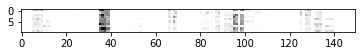

In [8]:
plt.imshow(activations_grid, cmap='gray_r')

### Stripe Average Activations

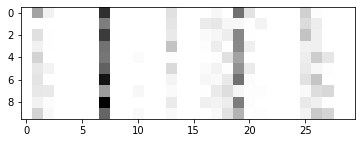

In [9]:
plt.imshow(stripe_activations_grid, cmap='gray_r')